In [1]:
# spacy 패키지 설치
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-08-28 05:34:01.706892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 05:34:02.664013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-28 05:34:04.742327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-28 05:34:04.742957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

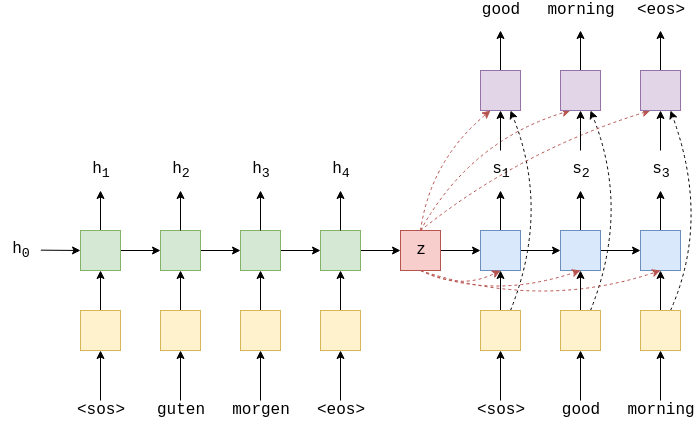

In [2]:
# Neural Machine Translation by Jointly Learning to Align and Translate 논문에서는 seq2seq model에 attention mechanism 을 적용함

# torchtext 패키지 설치
!pip install torchtext

# 이전의 seq2seq 와 마찬가지로 불러오기 및 데이터 버전 수정
# 최신 버전의 Pytorch에서는 Field, BucketIterator 가 torchtext.legacy.data 로 이전되었다고 하는데
# torchtext.legacy.data 로 불러와지지 않아서 옛날 버전으로 변경
# pip => python package 관리 도구 중
!pip install -U torchtext==0.6

# 만약에 런타임 재부팅 하라는 메시지가 나오면, 다시 처음부터 위에서부터 실행

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [3]:
# 라이브러리/모듈 불러오기

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
# Field : 텍스트 데이터를 처리하고 모델에 입력을 공급하기 위한 Field 객체. 텍스트 데이터의 전처리 및 후처리를 정의하는 객체
# BucketIterator : 데이터를 미니배치로 나누어주는 역할. 미니배치 크기, 데이터 정렬 방식 등을 설정할 수 있으며
#                  주어진 'Field' 객체에 따라 텍스트 데이터를 숫자로 변환하여 반환

import spacy
import numpy as np

import random
import math
import time

In [4]:
# 랜덤 SEED 설정
SEED = 1234

# random 모듈 랜덤 SEED 설정
random.seed(SEED)
# numpy 패키지 랜덤 모듈 numpy.random 랜덤 SEED 설정
np.random.seed(SEED)
# 파이토치 CPU 기반 랜덤 모듈 SEED 설정
torch.manual_seed(SEED)
# 파이토치 CUDA 랜덤 모듈 SEED 설정
torch.cuda.manual_seed(SEED)
# NVIDA cuDNN을 사용하는 경우 SEED 설정
torch.backends.cudnn.deterministic = True

In [5]:
# 공식 웹 사이트: https://spacy.io/models/de

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de_core_news_sm') # 독일어 토큰화(tokenization)

In [6]:
# 간단한 토큰화(tokenization) 기능
# 문장에 존재하는 각 word 레벨을 토큰으로, 고유한 인덱스를 부여
# 토큰(token) 에는 중요한 의미를 담는 어떤 데이터도 해당될 수 있음

tokenized = spacy_en.tokenizer("Song computer engineering tistory blog!  Song electric engineering naver blog.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

# 토큰화를 통해 문장을 단어의 나열(sequence of word)가 아닌 토큰의 나열(sequence of token)으로 해석
# token과 word 의 다른 점 : Song, computer, engineering, blog 등은 word 이면서 token 이지만, !, ., , 는 word는 아니지만 token 은 맞음.

인덱스 0: Song
인덱스 1: computer
인덱스 2: engineering
인덱스 3: tistory
인덱스 4: blog
인덱스 5: !
인덱스 6:  
인덱스 7: Song
인덱스 8: electric
인덱스 9: engineering
인덱스 10: naver
인덱스 11: blog
인덱스 12: .


In [7]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (seq2seq 때와 다르게 순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

tokenized = tokenize_en("Seq2Seq with attention paper Code Practice with Song")
print(tokenized) # 문장이 들어오면, 단어 단위, 특수문자 단위로 쪼개준다고 생각하면 편함.

['Seq2Seq', 'with', 'attention', 'paper', 'Code', 'Practice', 'with', 'Song']


In [8]:
# 토큰화 인수를 각각에 대한 토큰화 함수로 정의
# init_token:  토큰
# eos_token:  토큰
# lower : 모두 소문자로 처리 → 전체 토큰 수를 줄일 수 있기 때문에 모두 소문자로 처리
# 독일어는 Tource(SRC) Field
# 영어는 Target(TRG) Field

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

In [9]:
import torchtext

# 현재 다운로드 링크가 동작하지 않으므로, 동작되는 URL로 변경, 변경해도 text_dataset은 다운되지 않아 train, valid 만 다운로드
torchtext.datasets.Multi30k.urls = [
    r"https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    r"https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    r"https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz",
]

print(torchtext.datasets.Multi30k.urls)

['https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz', 'https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz', 'https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz']


In [10]:
from torchtext.datasets import Multi30k

# 총 30,000개의 (독일어, 영어) 쌍으로 구성된 데이터 세트
train_dataset, valid_dataset = Multi30k.splits(exts=(".de", ".en"),
                                               fields=(SRC, TRG),
                                               root='.custom_data',
                                               train="train",
                                               validation="val",
                                               test=None)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 9.28MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 2.70MB/s]


downloading mmt16_task1_test.tar.gz


mmt16_task1_test.tar.gz: 100%|██████████| 67.1k/67.1k [00:00<00:00, 3.04MB/s]


In [11]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개


In [12]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src']) # 순서를 바꿨기 때문에, 온점이 제일 첫째로 나옴.
print(vars(train_dataset.examples[30])['trg']) # 정상적인 순서

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


In [13]:
# 최소 두 번 이상 등장한 단어만 기록
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

# 한 번만 등장하는 희소한 단어는? unk 토큰으로 처리된다.
# 자연어 처리 분야에서 "특수 토큰"은 보통 4가지가 존재
  # 1) sos : 문장의 시작을 알림
  # 2) eos : 문장의 끝을 알림
  # 3) unk : 처음 보는 단어를 알림
  # 4) pad : 짧은 문장의 경우 뒤쪽을 패딩 토큰으로 채움

len(SRC): 7853
len(TRG): 5893


In [14]:
# string to index (stoi)
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) #  sos 토큰 : 2
print(TRG.vocab.stoi["<eos>"]) #  eos 토큰 : 3
print(TRG.vocab.stoi["hello"]) # 있는 단어는 해당 인덱스가 나타난다.
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [15]:
# torch.device 정의
# torchText 에게 텐서를 GPU에 넣었는지의 여부를 알려주는 데 사용
# GPU가 감지되면 True를 반환하는 torch.cuda.is_available() 함수 사용

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Iterator 정의
# src attribute(숫자화된 소스 문장의 텐서)와 trg attribute(숫자화된 타깃 문장의 텐서)를 가지는 data batch를 반환
# 문장들에서 패딩의 양을 최소화하는 방식으로 배치를 만들기 위해 표준 Iterator 대신 BucketIterator 사용

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [16]:
# Iterator 확인해보기
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[0]):
        print(f"인덱스 {i}: {src[i][0].item()}")

    # 첫 번째 배치만 확인
    break

# 첫 번째 배치 크기: torch.Size([23, 128])
# 현재 배치에 포함된 문장의 수가 128개 (batch_size = 128)
# 23 이 의미하는 것은 128개의 문장 중 가장 긴 문장의 토큰 개수를 의미

첫 번째 배치 크기: torch.Size([23, 128])
인덱스 0: 2
인덱스 1: 8
인덱스 2: 16
인덱스 3: 7
인덱스 4: 14
인덱스 5: 331
인덱스 6: 256
인덱스 7: 31
인덱스 8: 12
인덱스 9: 24
인덱스 10: 268
인덱스 11: 4
인덱스 12: 3
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1


### **Building the Seq2Seq with attention Model**
---

**Encoder**
2.png

In [17]:
# 인코더를 구현하는데, 이전의 Seq2Seq와는 다르게 양방향 RNN을 사용

# 인코더(Encoder) 아키텍처 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, enc_hidden_dim, dec_hidden_dim, dropout_ratio):
        super().__init__()

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding)을 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # 양방향(bidirectional) GRU 레이어
        self.rnn = nn.GRU(embed_dim, enc_hidden_dim, bidirectional=True)

        # FC 레이어, 2를 곱해주는 것은 양방향 GRU 레이어로부터 온 정보를 하나의 hidden state 로 합치기 위함
        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)

        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더는 소스 문장을 입력으로 받아 문맥 벡터(context vector)를 반환
    def forward(self, src):
        # (배치 사이즈 2로 가정)
        # src = ["I love you", "I like you so much"]
        # src = [" I love you   ", " I like you so much "] => [2, 7(뒤의 단어가 5개의 토큰 + sos, eos)]의 크기
        # src[0] 예시) [2, 375, 284, 1938, 1, 1, 3]
        # 입력을 넣기 위해서는 transpose가 필요
        """
        transpose를 함으로써 비로소 [7, 2]의 크기가 됨.
        src = [
          [, ],
          ["I", "I"],
          ["love", "like"],
          ["you", "you"],
          [, "so"],
          [, "much"],
          [, ]
        ]
        """

        # src: [단어 개수, 배치 크기]: 각 단어의 인덱스(index) 정보
        embedded = self.dropout(self.embedding(src))
        # embedded: [단어 개수, 배치 크기, 임베딩 차원]

        outputs, hidden = self.rnn(embedded)
        # (현재 예시에서는 방향의 수 = 2)
        # outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 "모든" hidden state 정보
        # hidden: [레이어 개수 * 방향의 수, 배치 크기, 인코더 히든 차원]: 현재까지의 모든 단어의 정보(마지막 단어에서의 hidden state)

        # hidden은 [forward_1, backward_1, forward_2, backward_2, ...] 형태로 번갈아가며 구성됨.
        # 따라서 hidden[-2, :, :]은 forwards의 마지막 값을 의미
        # 따라서 hidden[-1, :, :]은 backwards의 마지막 값을 의미
        # 디코더(decoder)의 첫 번째 hidden (context) vector는 인코더의 마지막 hidden을 이용
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        # outputs은 Attention 목적으로, hidden은 context vector 목적으로 사용
        # outputs = [src len, batch size, enc hid dim * 2]
        # hidden = [batch size, dec hid dim]
        return outputs, hidden

**Attention**
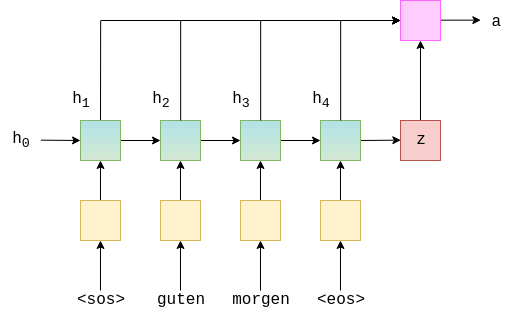

In [18]:
import torch.nn.functional as F

# 어텐션(Attention) 아키텍처 정의
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, enc_outputs):
        # hidden: [배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보
        # enc_outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보
        batch_size = enc_outputs.shape[1]
        src_len = enc_outputs.shape[0]

        # 현재 디코더의 히든 상태(hidden state)를 src_len만큼 반복
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        enc_outputs = enc_outputs.permute(1, 0, 2)
        # hidden: [배치 크기, 단어 개수, 디코더 히든 차원]: 현재까지의 모든 단어의 정보
        # enc_outputs: [배치 크기, 단어 개수, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보

        energy = torch.tanh(self.attn(torch.cat((hidden, enc_outputs), dim=2)))
        # energy: [배치 크기, 단어 개수, 디코더 히든 차원]

        attention = self.v(energy).squeeze(2)
        # attention: [배치 크기, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들

        return F.softmax(attention, dim=1)

**Decoder**
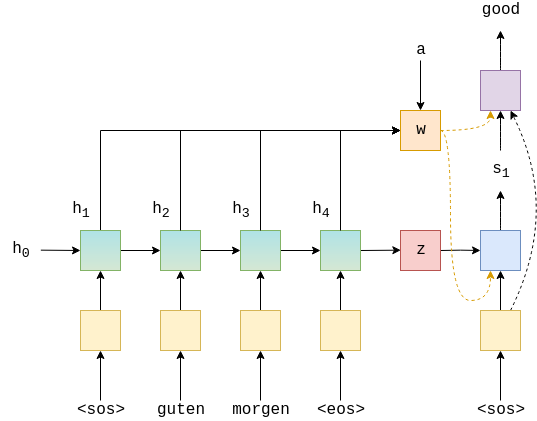

In [19]:
# 디코더(Decoder) 아키텍처 정의
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, enc_hidden_dim, dec_hidden_dim, dropout_ratio, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding) 말고 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(output_dim, embed_dim)

        # GRU 레이어
        self.rnn = nn.GRU((enc_hidden_dim * 2) + embed_dim, dec_hidden_dim)

        # FC 레이어
        self.fc_out = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim + embed_dim, output_dim)

        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 디코더는 현재까지 출력된 문장에 대한 정보를 입력으로 받아 타겟 문장을 반환
    def forward(self, input, hidden, enc_outputs):
        # input: [배치 크기]: 단어의 개수는 항상 1개이도록 구현
        # hidden: [배치 크기, 히든 차원]
        # enc_outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보
        input = input.unsqueeze(0)
        # input: [단어 개수 = 1, 배치 크기]

        embedded = self.dropout(self.embedding(input))
        # embedded: [단어 개수 = 1, 배치 크기, 임베딩 차원]

        attention = self.attention(hidden, enc_outputs)
        # attention: [배치 크기, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들
        attention = attention.unsqueeze(1)
        # attention: [배치 크기, 1, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들

        enc_outputs = enc_outputs.permute(1, 0, 2)
        # enc_outputs: [배치 크기, 단어 개수, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보

        weighted = torch.bmm(attention, enc_outputs) # 행렬 곱 함수
        # weighted: [배치 크기, 1, 인코더 히든 차원 * 방향의 수]

        weighted = weighted.permute(1, 0, 2)
        # weighted: [1, 배치 크기, 인코더 히든 차원 * 방향의 수]

        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input: [1, 배치 크기, 인코더 히든 차원 * 방향의 수 + embed_dim]: 어텐션이 적용된 현재 단어 입력 정보

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output: [단어 개수, 배치 크기, 디코더 히든 차원 * 방향의 수]
        # hidden: [레이어 개수 * 방향의 수, 배치 크기, 디코더 히든 차원]: 현재까지의 모든 단어의 정보

        # 현재 예제에서는 단어 개수, 레이어 개수, 방향의 수 모두 1의 값을 가짐
        # 따라서 output: [1, 배치 크기, 디코더 히든 차원], hidden: [1, 배치 크기, 디코더 히든 차원]
        # 다시 말해 output과 hidden의 값 또한 동일
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [배치 크기, 출력 차원]

        # (현재 출력 단어, 현재까지의 모든 단어의 정보)
        return prediction, hidden.squeeze(0)

**디코더 코드 수식과 연관지은 설명**
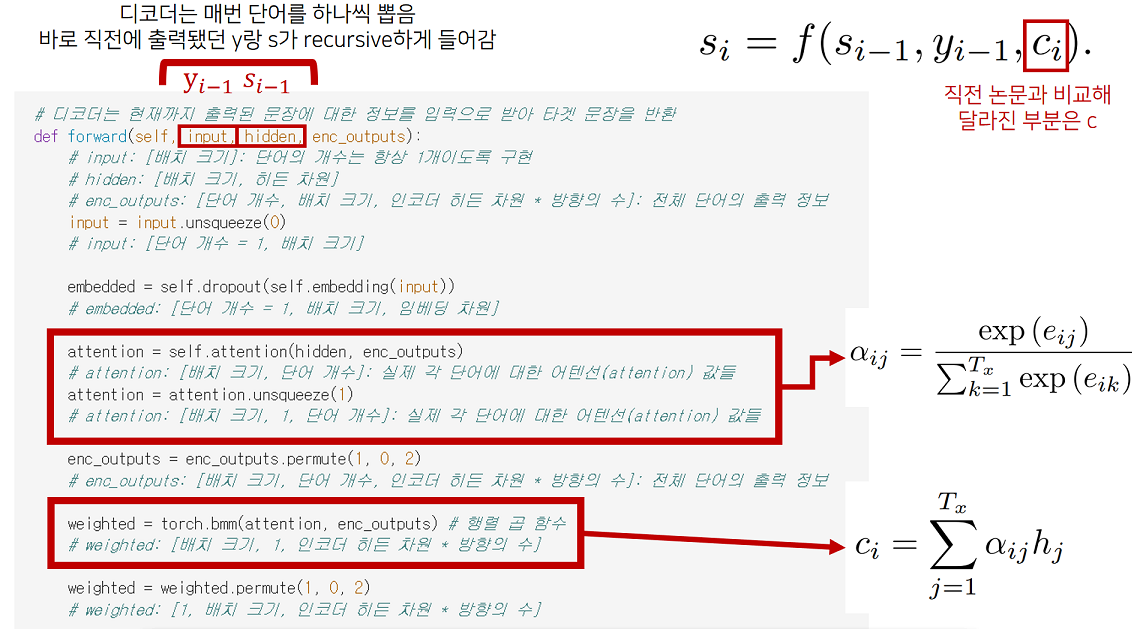

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    # 학습할 때는 완전한 형태의 소스 문장, 타겟 문장, teacher_forcing_ratio를 넣기
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [단어 개수, 배치 크기]
        # trg: [단어 개수, 배치 크기]
        # 먼저 인코더를 거쳐 전체 출력과 문맥 벡터(context vector)를 추출
        enc_outputs, hidden = self.encoder(src)

        # 디코더(decoder)의 최종 결과를 담을 텐서 객체 만들기
        trg_len = trg.shape[0] # 단어 개수
        batch_size = trg.shape[1] # 배치 크기
        trg_vocab_size = self.decoder.output_dim # 출력 차원
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 첫 번째 입력은 항상  토큰
        input = trg[0, :]

        # 타겟 단어의 개수만큼 반복하여 디코더에 포워딩(forwarding)
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, enc_outputs)

            outputs[t] = output # FC를 거쳐서 나온 현재의 출력 단어 정보
            top1 = output.argmax(1) # 가장 확률이 높은 단어의 인덱스 추출

            # teacher_forcing_ratio: 학습할 때 실제 목표 출력(ground-truth)을 사용하는 비율
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else top1 # 현재의 출력 결과를 다음 입력에서 넣기

        return outputs

### **Training the Seq2Seq with attention Model**
---

In [21]:
# 모델 초기화

# 입력과 출력 차원은 어휘의 전체 크기가 결정
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256 # 각 토큰(단어)가 표현되는 차원
DECODER_EMBED_DIM = 256 # 각 토큰(단어)가 표현되는 차원
ENCODER_HIDDEN_DIM = 512  # 인코더 hidden dim
DECODER_HIDDEN_DIM = 512  # 디코더 hidden dim
ENC_DROPOUT_RATIO = 0.5 # dropout => 모델 성능 향상 기법 중 하나
DEC_DROPOUT_RATIO = 0.5 # dropout => 모델 성능 향상 기법 중 하나

In [22]:
# 어텐션(attention) 객체 선언
attn = Attention(ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM)

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, ENCODER_EMBED_DIM, ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, ENC_DROPOUT_RATIO)
dec = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, DEC_DROPOUT_RATIO, attn)

# Seq2Seq 객체 선언
model = Seq2Seq(enc, dec, device).to(device)

In [23]:
# 논문에서 사용된 가중치 초기화 방법의 단순화된 버전 사용
# 평균을 0으로 만들고, 표준편차가 0.01인 정규분포에서 뽑은 랜덤한 값을 사용해 초기화

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [24]:
# 파라미터의 수를 계산하는 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [25]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
optimizer = optim.Adam(model.parameters())

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# loss function 초기화
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [26]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)
        # output: [출력 단어 개수, 배치 크기, 출력 차원]
        output_dim = output.shape[-1]

        # 출력 단어의 인덱스 0은 사용하지 않음
        output = output[1:].view(-1, output_dim)
        # output = [(출력 단어의 개수 - 1) * batch size, output dim]
        trg = trg[1:].view(-1)
        # trg = [(타겟 단어의 개수 - 1) * batch size]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 평가할 때 teacher forcing는 사용하지 않음
            output = model(src, trg, 0)
            # output: [출력 단어 개수, 배치 크기, 출력 차원]
            output_dim = output.shape[-1]

            # 출력 단어의 인덱스 0은 사용하지 않음
            output = output[1:].view(-1, output_dim)
            # output = [(출력 단어의 개수 - 1) * batch size, output dim]
            trg = trg[1:].view(-1)
            # trg = [(타겟 단어의 개수 - 1) * batch size]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [28]:
# epoch 당 소요시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq_with_attention.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 1m 30s
	Train Loss: 5.023 | Train PPL: 151.821
	Validation Loss: 4.815 | Validation PPL: 123.317
Epoch: 02 | Time: 1m 28s
	Train Loss: 4.101 | Train PPL: 60.420
	Validation Loss: 4.320 | Validation PPL: 75.215
Epoch: 03 | Time: 1m 28s
	Train Loss: 3.421 | Train PPL: 30.594
	Validation Loss: 3.737 | Validation PPL: 41.956
Epoch: 04 | Time: 1m 28s
	Train Loss: 2.874 | Train PPL: 17.711
	Validation Loss: 3.408 | Validation PPL: 30.193
Epoch: 05 | Time: 1m 29s
	Train Loss: 2.493 | Train PPL: 12.102
	Validation Loss: 3.224 | Validation PPL: 25.134
Epoch: 06 | Time: 1m 28s
	Train Loss: 2.173 | Train PPL: 8.787
	Validation Loss: 3.232 | Validation PPL: 25.327
Epoch: 07 | Time: 1m 29s
	Train Loss: 1.951 | Train PPL: 7.036
	Validation Loss: 3.191 | Validation PPL: 24.305
Epoch: 08 | Time: 1m 29s
	Train Loss: 1.732 | Train PPL: 5.652
	Validation Loss: 3.267 | Validation PPL: 26.235
Epoch: 09 | Time: 1m 29s
	Train Loss: 1.574 | Train PPL: 4.825
	Validation Loss: 3.337 | Validati

In [30]:
model.load_state_dict(torch.load('seq2seq_with_attention.pt'))

# text 데이터를 정상으로 불러왔다면 가장 좋은 validation loss 를 기록한 모델(state_dict)을 불러와 성능 측정할 수 있음
# test_loss = evaluate(model, test_iterator, criterion)
# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

# test 데이터가 없는 상황이므로, 제일 잘 학습된 validation model 을 확인하고 마무리
valid_loss = evaluate(model, valid_iterator, criterion)
print(f'| Validation Loss: {valid_loss:.3f} | Test PPL: {math.exp(valid_loss):7.3f} |')

| Validation Loss: 3.191 | Test PPL:  24.305 |


In [31]:
# seq2seq 모델 학습 결과 : | Validation Loss: 3.979 | Test PPL:  53.454 |
# attention 을 적용한 모델이 Loss 가 더 적은 것을 확인할 수 있음